# Estimate gate error due to decoherence effect

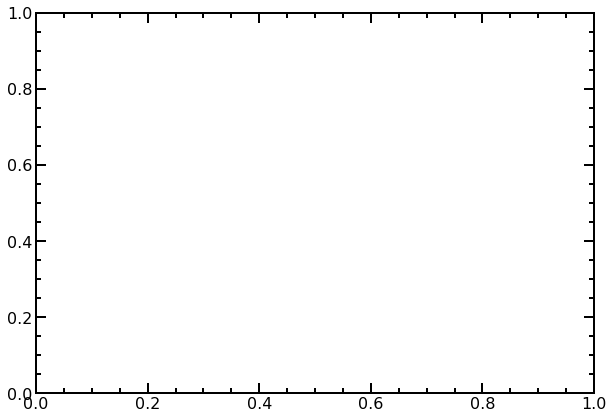

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import scipy.linalg

## Single qubit

In [2]:
#Define qubit
wq = 5
H_nodrive = 0.5*wq*sigmaz()
H_drive = sigmax()

#Define drive
wd=wq
T_gate = 20
shape = 'square'
drive_freq = wq
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

#Decoherence
def c_ops_func(t1, t2):
    gamma1 = 1.0/t1
    gamma2 = 1.0/t2
    gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sigmam())
    c2 = np.sqrt(gamma_phi/2.0) *(sigmaz())
    return [c1, c2]

In [ ]:
#Evolve using propagator
c_ops = c_ops(1e3, 1e3)
U_ideal = gates.evolution_operator_microwave(H_nodrive, H_drive, t=t_points,
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
psi0 = basis(2,0)
psi1 = basis(2,1)
P0 = psi0*psi0.dag()
plt.plot(t_points, expect(P0,U_ideal*psi0))

U_real = gates.evolution_operator_microwave_diss(H_nodrive, H_drive, t=t_points, c_ops = c_ops,
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq, parallel = True)
plt.plot(t_points, expect(P0,U_ideal*psi0))

0.9974741954534595
0.9949547705955264
0.9974741954544243


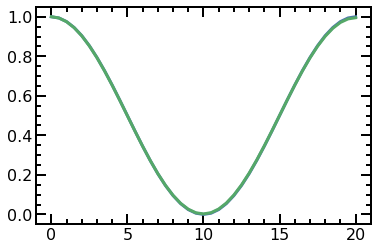

In [3]:
#Evolve using master equation solver
psi0 = basis(2,0)
psi1 = basis(2,1)
P0 = psi0*psi0.dag()
evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi0, t=t_points,
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_ideal))

evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi0, t=t_points, c_ops= c_ops_func(2e3, 2e3),
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_real))

rho_ideal = ket2dm(evol_states_ideal[-1])
rho_real = evol_states_real[-1]
print (qutip.fidelity(rho_ideal, rho_real))
print ((rho_ideal*rho_real).tr())
fidel = (rho_real.sqrtm() * rho_ideal * rho_real.sqrtm()).sqrtm().tr()
print (fidel)

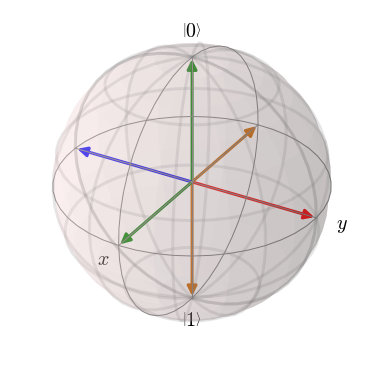

In [4]:
from qutip.qip.operations import rx, ry
rotation = [identity(2), rx(np.pi), rx(np.pi/2), rx(-np.pi/2), ry(np.pi/2), ry(-np.pi/2)]
psi_ini = rotation * psi0
b = Bloch()
b.add_states(psi_ini)
b.make_sphere()

In [7]:
t_coh = np.linspace(1e3, 10e3, 10)
fidel = np.zeros_like(t_coh)

for idx, t in enumerate(t_coh):
    c_ops = c_ops_func (10e6, t)
    overlap = 0
    for psi in psi_ini:
        evol_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0=psi, t=t_points,
                                                T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
        rho_ideal = ket2dm(evol_ideal)
        rho_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0=psi, t=t_points, c_ops= c_ops,
                                                T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
        overlap = overlap + (rho_real*rho_ideal).tr()
    fidel[idx] = abs(overlap)/6.0
    
gamma1 = 1.0/1e6
gamma2 = 1.0/t_coh
gamma_phi = gamma2 - gamma1/2.0
T_err = (gamma_phi+gamma1)**-1.0*3

Text(0.5, 1.0, 'SQG decoherence error')

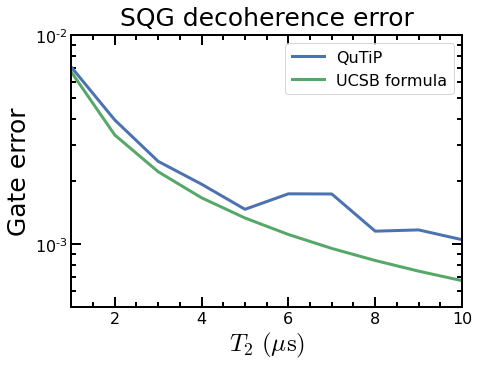

In [13]:
plt.figure(figsize = [7,5])
plt.semilogy(t_coh/1e3, 1-fidel, label = 'QuTiP')
plt.semilogy(t_coh/1e3, T_gate/T_err, label = 'UCSB formula')
# plt.semilogy(t_coh/1e3, T_gate/t_coh, label = r'$T_g/T_2$')
plt.xlabel(r'$T_2~(\mathrm{\mu s})$')
plt.ylabel('Gate error')
plt.ylim([5e-4,1e-2])
plt.xlim([t_coh[0]/1e3,t_coh[-1]/1e3])
plt.legend()
plt.title('SQG decoherence error')

## Three qubits

In [7]:
sz1 = tensor(sigmaz(), identity(2), identity(2))
sz2 = tensor(identity(2), sigmaz(), identity(2))
sz3 = tensor(identity(2), identity(2), sigmaz())
sx1 = tensor(sigmax(), identity(2), identity(2))
sx2 = tensor(identity(2), sigmax(), identity(2))
sx3 = tensor(identity(2), identity(2), sigmax())
sm1 = tensor(sigmam(), identity(2), identity(2))
sm2 = tensor(identity(2), sigmam(), identity(2))
sm3 = tensor(identity(2), identity(2), sigmam())
    
def toffoli_H_coupled(freq1, freq2, freq3, g):
    return (0.5*freq1*sz1 + 0.5*freq2*sz2 + 0.5*freq3*sz3 + g*sx1*sx2 + g*sx2*sx3)

def toffoli_collapse_ops(t1,t2):
    gamma1 = 1.0/t1
    gamma2 = 1.0/t2
    gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sm1 + sm2 + sm3)
    c2 = np.sqrt(gamma_phi/2.0) *(sz1 + sz2 + sz3)
    c_ops = [c1, c2]
    return c_ops

freq1 = 5.2541
freq2 = 5.331
freq3 = 5.491
g = 2.74 * 1e-3
T_gate = 340
shape = 'gauss'
drive_freq = freq2
drive_amp = 1
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_nodrive = toffoli_H_coupled(freq1, freq2, freq3, g)
H_drive = drive_amp*(sx1 + sx3)
psi0 = tensor(basis(2,0),basis(2,0),basis(2,0))

t1_toff = 50e3
t2_toff = 60e3
c_ops_toff = toffoli_collapse_ops(t1_toff,t2_toff)

Done


In [9]:
overlap = 0
for p1_idx in range(6):
    for p2_idx in range(6):
        for p3_idx in range(6):
            psi_ini = tensor(rotation[p1_idx], rotation[p2_idx], rotation[p2_idx])*psi0
            evol_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0=psi_ini, t=t_points,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            rho_ideal = ket2dm(evol_ideal)
            rho_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0=psi_ini, t=t_points, c_ops=c_ops_toff,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            overlap = overlap + (rho_real*rho_ideal).tr()
fidel = abs(overlap)/(6.0**3)
print (fidel)

0.9810469190641585


In [10]:
print (qutip.Options())

Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          8
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False

